# Analysis of hover points

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from firefly_preprocessing import get_dfs
import scipy
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
from scipy import signal
from tools import data_loader

In [2]:
%%capture

data_directory = ['../flight_data/2021-12-10_hangar', '../flight_data/2022-01-24_hangar',
                  '../flight_data/2022-01-24_hangar']

ulg_number = [109, 143, 145]
firefly_number = [54, 5, 9]

log_number = 2
firefly_df, arm_df, ulg_df = get_dfs(data_directory[log_number],
                                         ulg_number[log_number], firefly_number[log_number])

In [3]:
# get motor data

current = data_loader.get_current(firefly_df)
voltage = data_loader.get_voltage(firefly_df)
rpm = data_loader.get_rpm(firefly_df)
power = data_loader.get_power(firefly_df)

total_power = sum(power.values())

time = firefly_df.index.values

In [4]:
# get positions, velocities and angular rates

x = ulg_df['ulg_pv_df']['x'].values
y = ulg_df['ulg_pv_df']['y'].values
z = ulg_df['ulg_pv_df']['z'].values

u = ulg_df['ulg_pv_df']['vx'].values
v = ulg_df['ulg_pv_df']['vy'].values
w = ulg_df['ulg_pv_df']['vz'].values

p = ulg_df['ulg_angvel_df']['roll rate'].values
q = ulg_df['ulg_angvel_df']['pitch rate'].values
r = ulg_df['ulg_angvel_df']['yaw rate'].values

In [12]:
# global plotting settings
markersize = 3
cmap = cm.cool

# set t0 and t1 to plot only part of time domain
t0 = 0
t1 = time.size

In [13]:
# calculate velocity throug derivation of position

dt = time[1] - time[0]
dy = np.gradient(y, dt)
dx = np.gradient(x, dt)
dz = np.gradient(z, dt)

# reverse derivation by taking the integral
#pos_int = scipy.integrate.cumtrapz(dy, x=time, initial = 0)


<IPython.core.display.Javascript object>


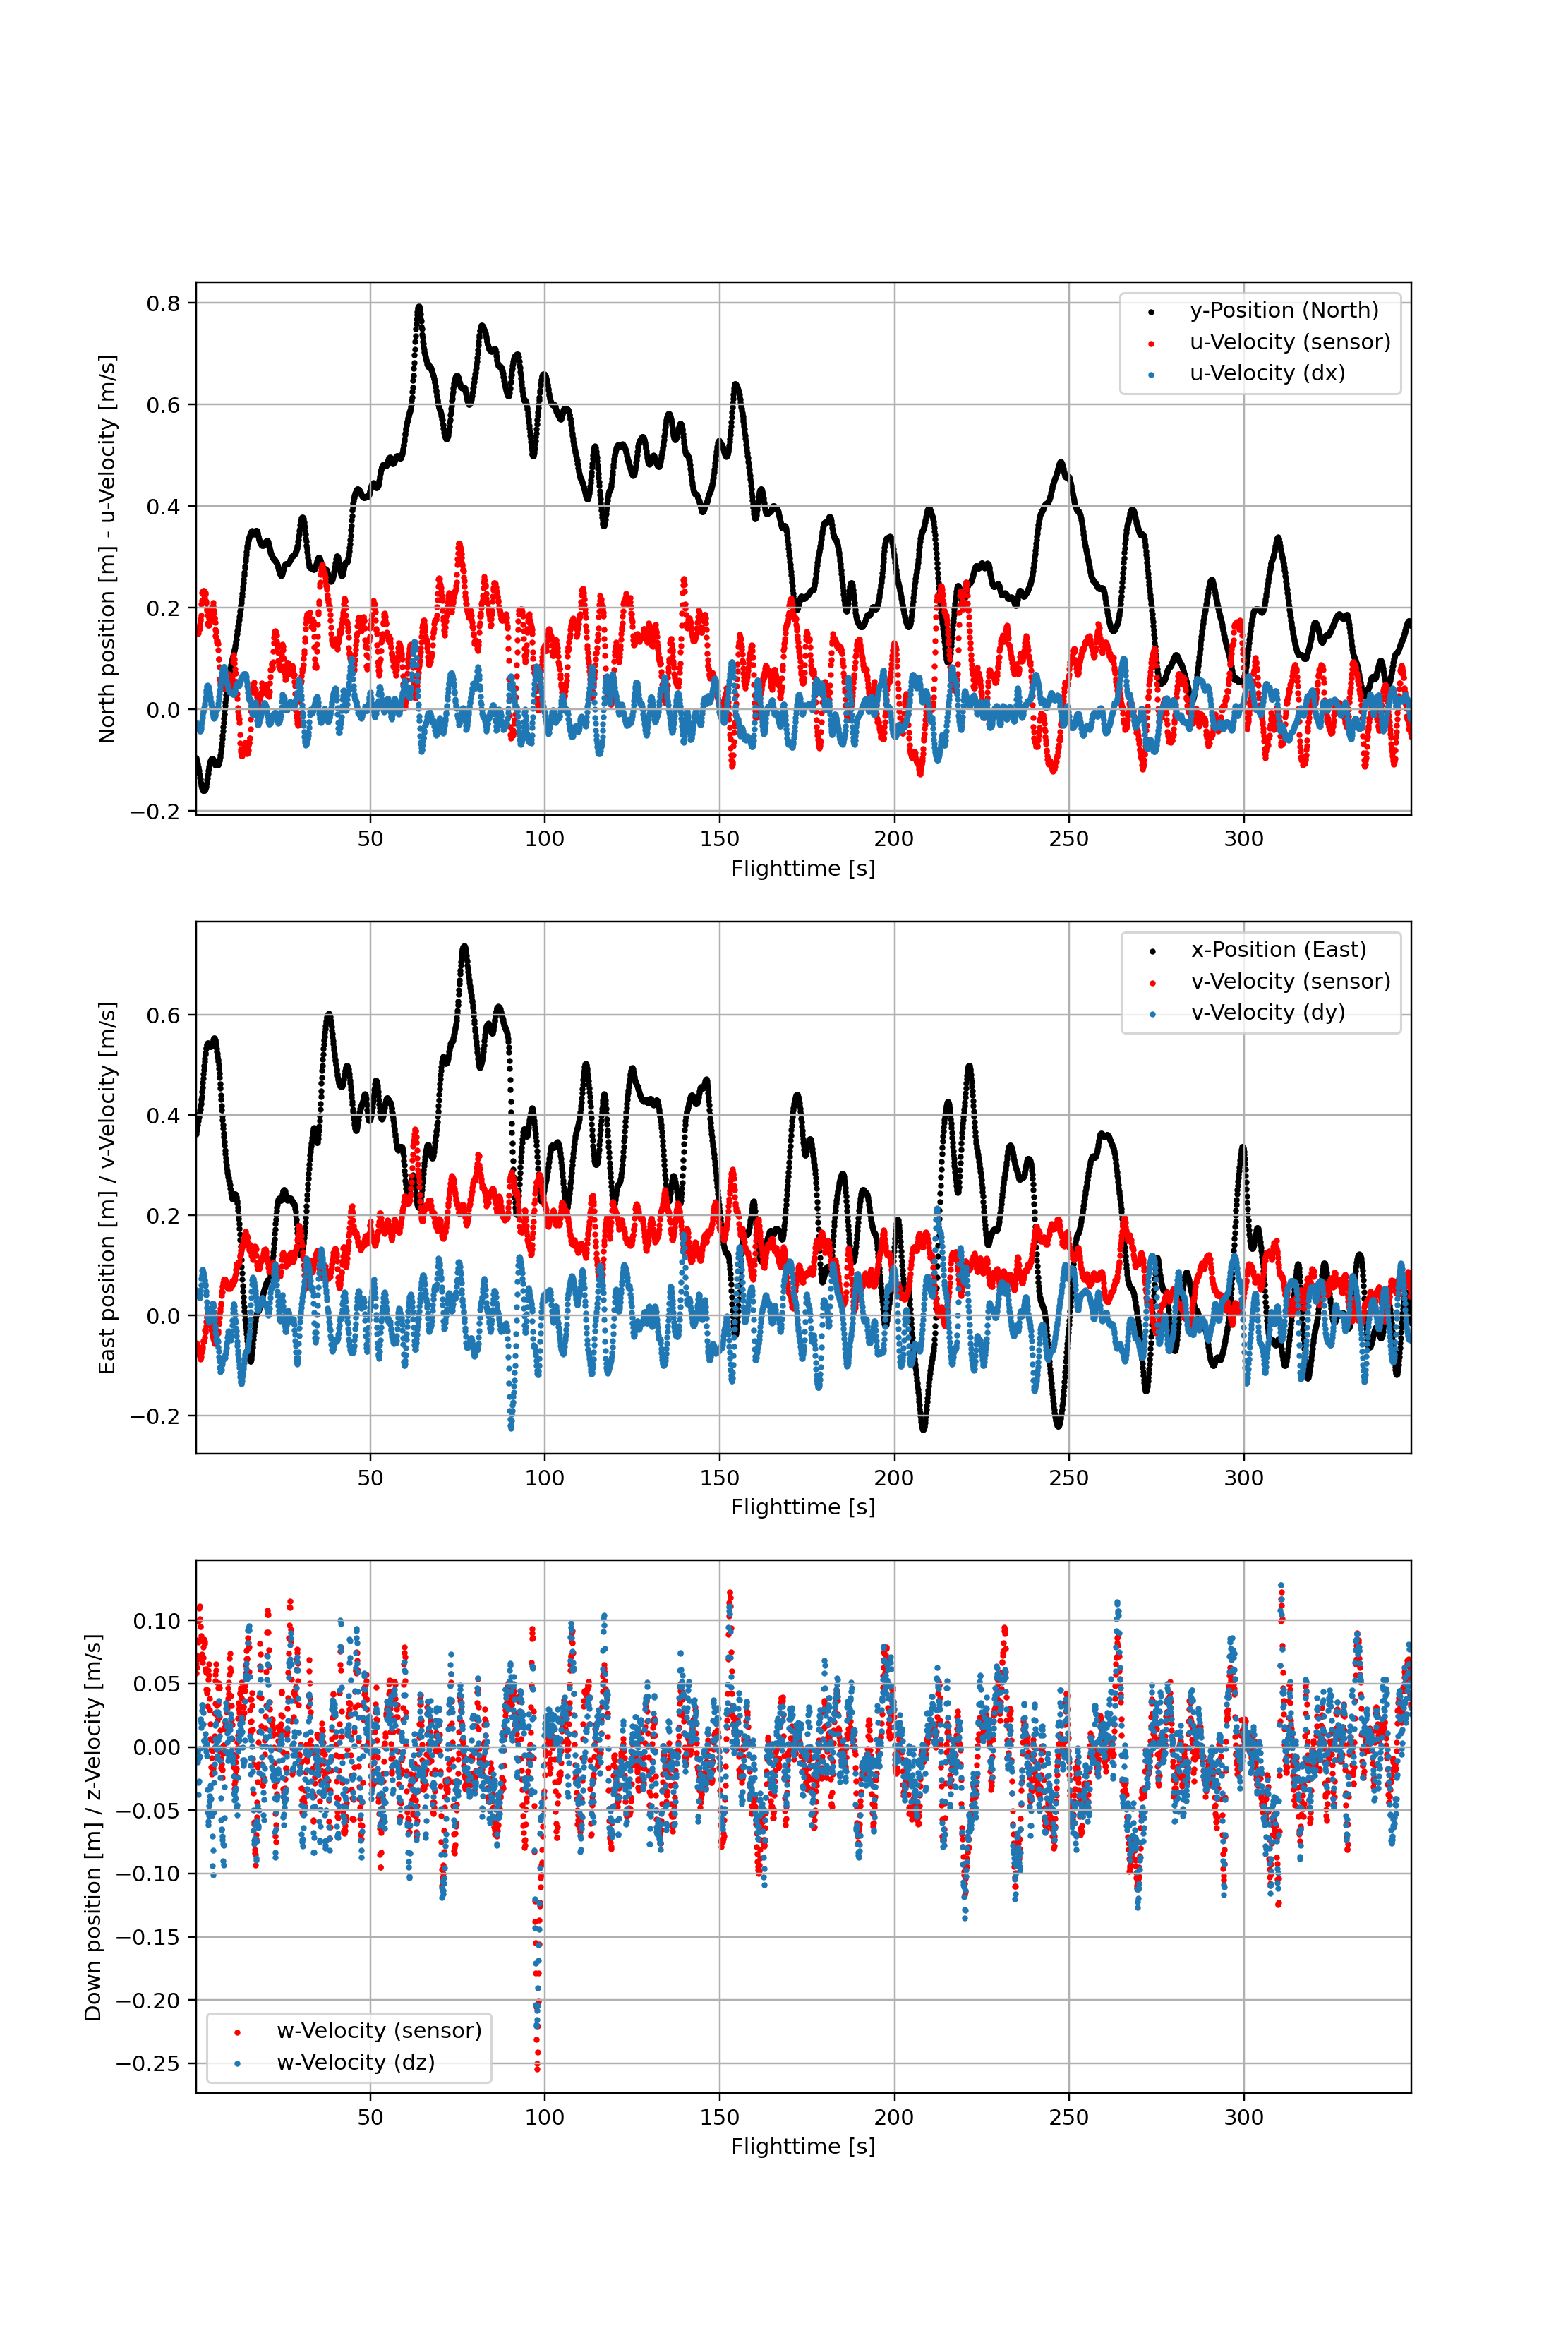

Text(0, 0.5, 'Down position [m] / z-Velocity [m/s]')

In [14]:
# plot sensor values and calculated values for position and velocity

fig1, ax1 = plt.subplots(3,1, figsize=(10,15))

# plot position from sensor
ax1[0].scatter(time[t0:t1], y[t0:t1], c='k', label='y-Position (North)', s=markersize)
ax1[1].scatter(time[t0:t1], x[t0:t1], c='k', label='x-Position (East)', s=markersize)
#ax1[2].scatter(time[t0:t1], z[t0:t1], c='k', label='z (Down)', s=markersize)

# plot velocity from sensor
ax1[0].scatter(time[t0:t1], u[t0:t1], c='r', label='u-Velocity (sensor)', s=markersize)
ax1[1].scatter(time[t0:t1], v[t0:t1], c='r', label='v-Velocity (sensor)', s=markersize)
ax1[2].scatter(time[t0:t1], w[t0:t1], c='r', label='w-Velocity (sensor)', s=markersize)
#ax1.scatter(time[t0:t1], u[t0:t1]-curve.reshape(-1)[t0:t1], c='r', label='u (sensor)', s=markersize)

# plot derived velocity
ax1[0].scatter(time[t0:t1], dy[t0:t1], c='tab:blue', label='u-Velocity (dx)', s=markersize)
ax1[1].scatter(time[t0:t1], dx[t0:t1], c='tab:blue', label='v-Velocity (dy)', s=markersize)
ax1[2].scatter(time[t0:t1], dz[t0:t1], c='tab:blue', label='w-Velocity (dz)', s=markersize)

# plot integrated position
#ax1.scatter(time[t0:t1], pos_int[t0:t1], c='tab:cyan', label='North (integrated)', s=markersize)

for i in range(3):
    ax1[i].set_xlim(time[0], time[-1])
    ax1[i].grid()
    ax1[i].legend()
    ax1[i].set_xlabel('Flighttime [s]')

ax1[0].set_ylabel('North position [m] - u-Velocity [m/s]')
ax1[1].set_ylabel('East position [m] / v-Velocity [m/s]')
ax1[2].set_ylabel('Down position [m] / z-Velocity [m/s]')

## Findings
* velocity signal in north and east direction does not match position signal -> both u and v are constantly above 0, the vehicle would drift away, if they were correct

<IPython.core.display.Javascript object>


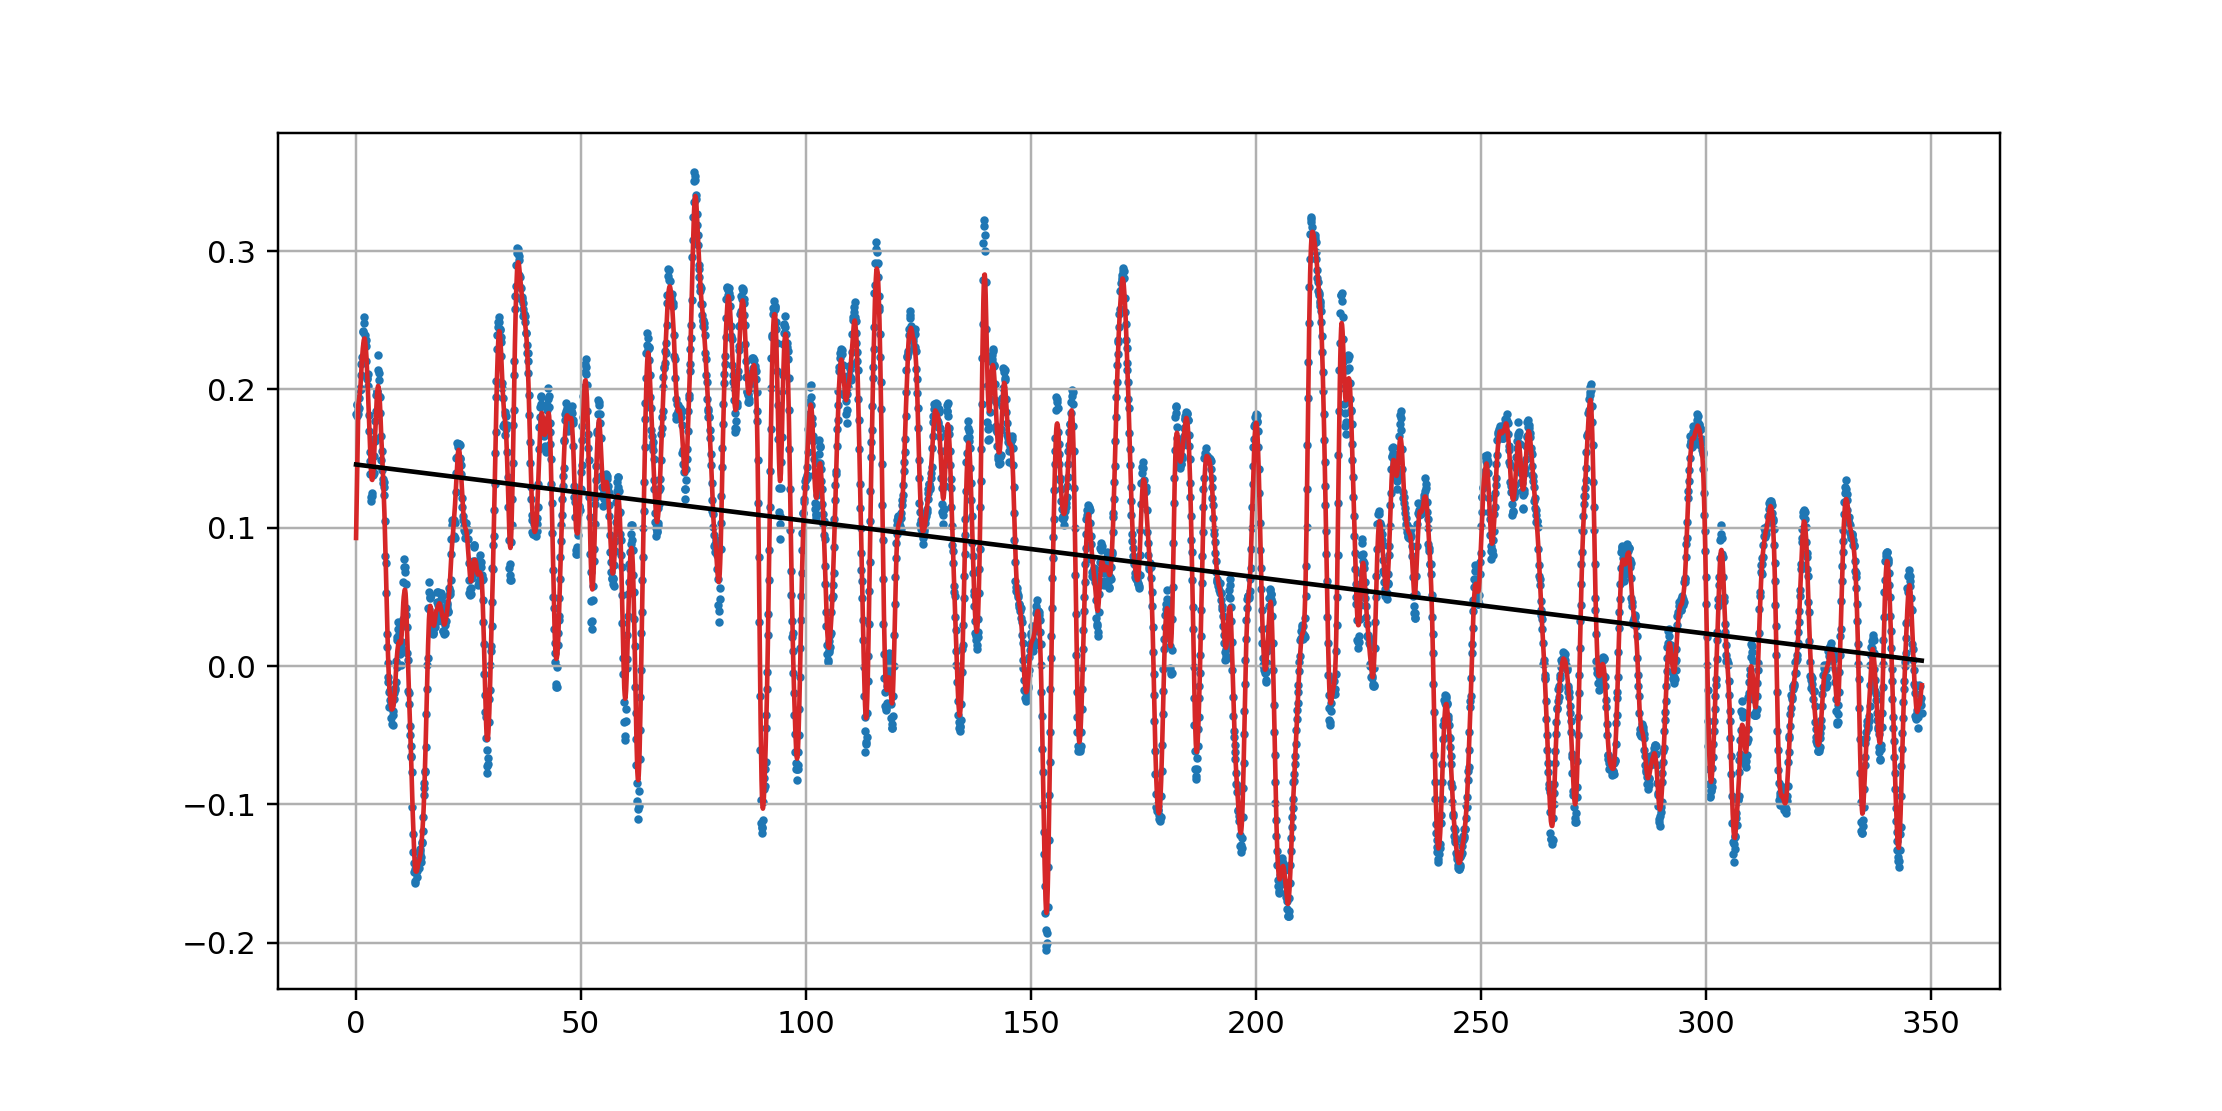

In [15]:
# Plot difference between sensor velocity and derived velocity
velocity_difference = u - dy
velocity_difference_filtered = np.convolve(velocity_difference, np.ones(10),'same')/10
fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.scatter(time, velocity_difference, s=markersize)
ax2.plot(time, velocity_difference_filtered, c='tab:red')

reg = linear_model.LinearRegression().fit(time.reshape(-1,1), velocity_difference.reshape(-1,1))
curve = reg.predict(time.reshape(-1,1))
ax2.plot(time, curve, 'k')
ax2.grid()

In [16]:
# calculate induced velocity
W = 15*9.81
rho = 1.225
A = np.pi * (0.3048**2)
v_i = np.sqrt((2*W)/(rho*4*A))

# set 1% of v_i as a threshold for the maximum vnorm


# get norm
#v_norm = ulg_df['ulg_pv_df']['vnorm'].values
v_norm = np.sqrt(u**2 + v**2 + w**2)
dv_norm = np.sqrt(dx**2 + dy**2 + dz**2)
test = np.sqrt(dx**2 + dy**2 + dz**2)

In [17]:
# set percentage of induced velocity as a limit
v_limit = 0.06
dv_limit = 0.06

In [18]:
# filter out values above v_limit
v_norm_filtered = np.where(v_norm < v_limit)[0]
dv_norm_filtered = np.where(dv_norm < dv_limit)[0]

<IPython.core.display.Javascript object>


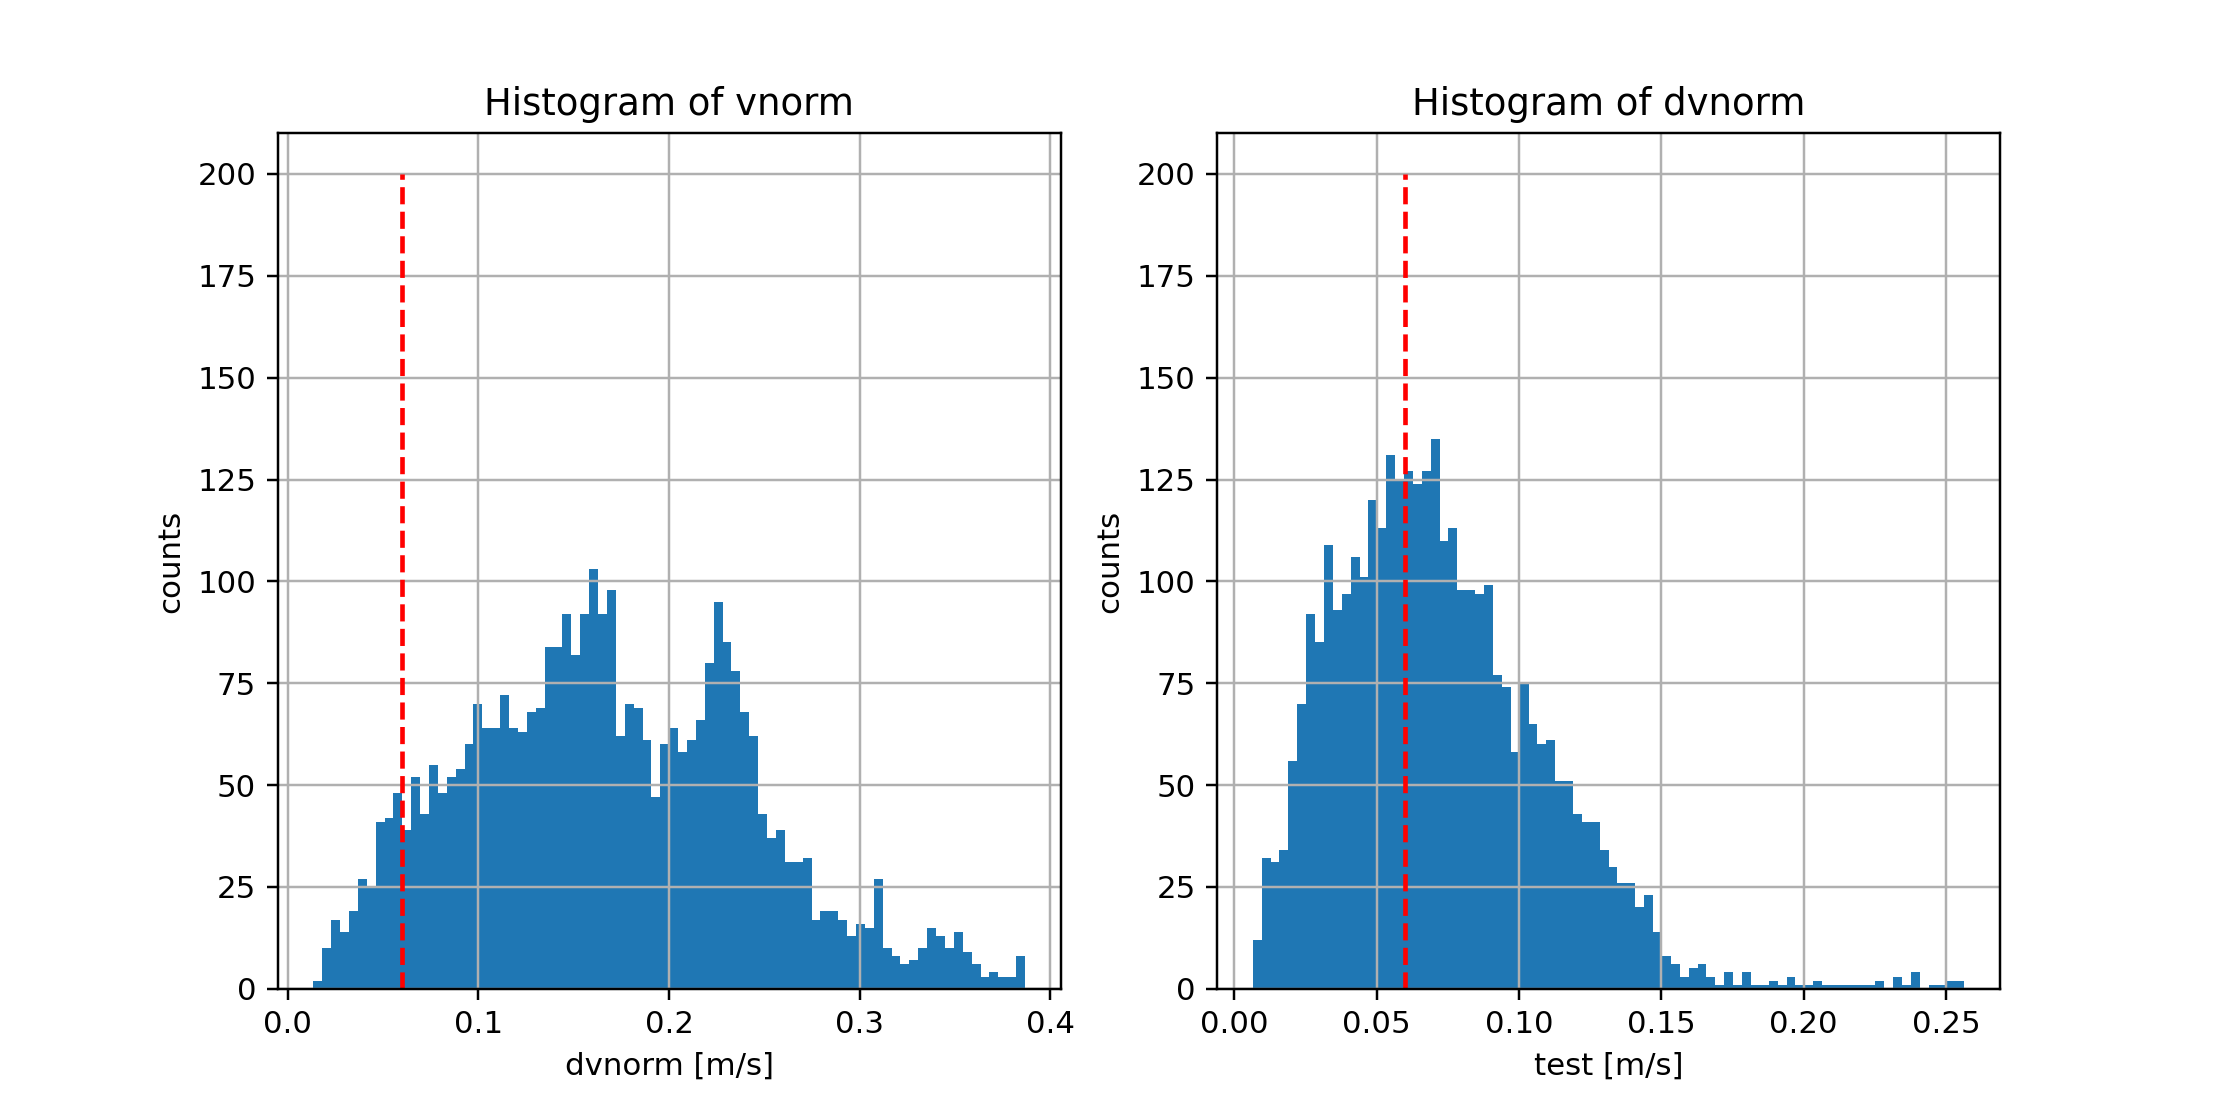

In [19]:
fig4, ax4 = plt.subplots(1, 2, figsize=(10,5))

ax4[0].hist(v_norm, bins=80)
ax4[0].plot([v_limit, v_limit],[0, 200], 'r--')
ax4[0].set_xlabel('dvnorm [m/s]')
ax4[0].set_ylabel('counts')
ax4[0].set_title('Histogram of vnorm')
ax4[0].grid()

ax4[1].hist(dv_norm, bins=80)
ax4[1].plot([dv_limit, dv_limit],[0, 200], 'r--')
ax4[1].set_xlabel('test [m/s]')
ax4[1].set_ylabel('counts')
ax4[1].set_title('Histogram of dvnorm')
ax4[1].grid()


<IPython.core.display.Javascript object>


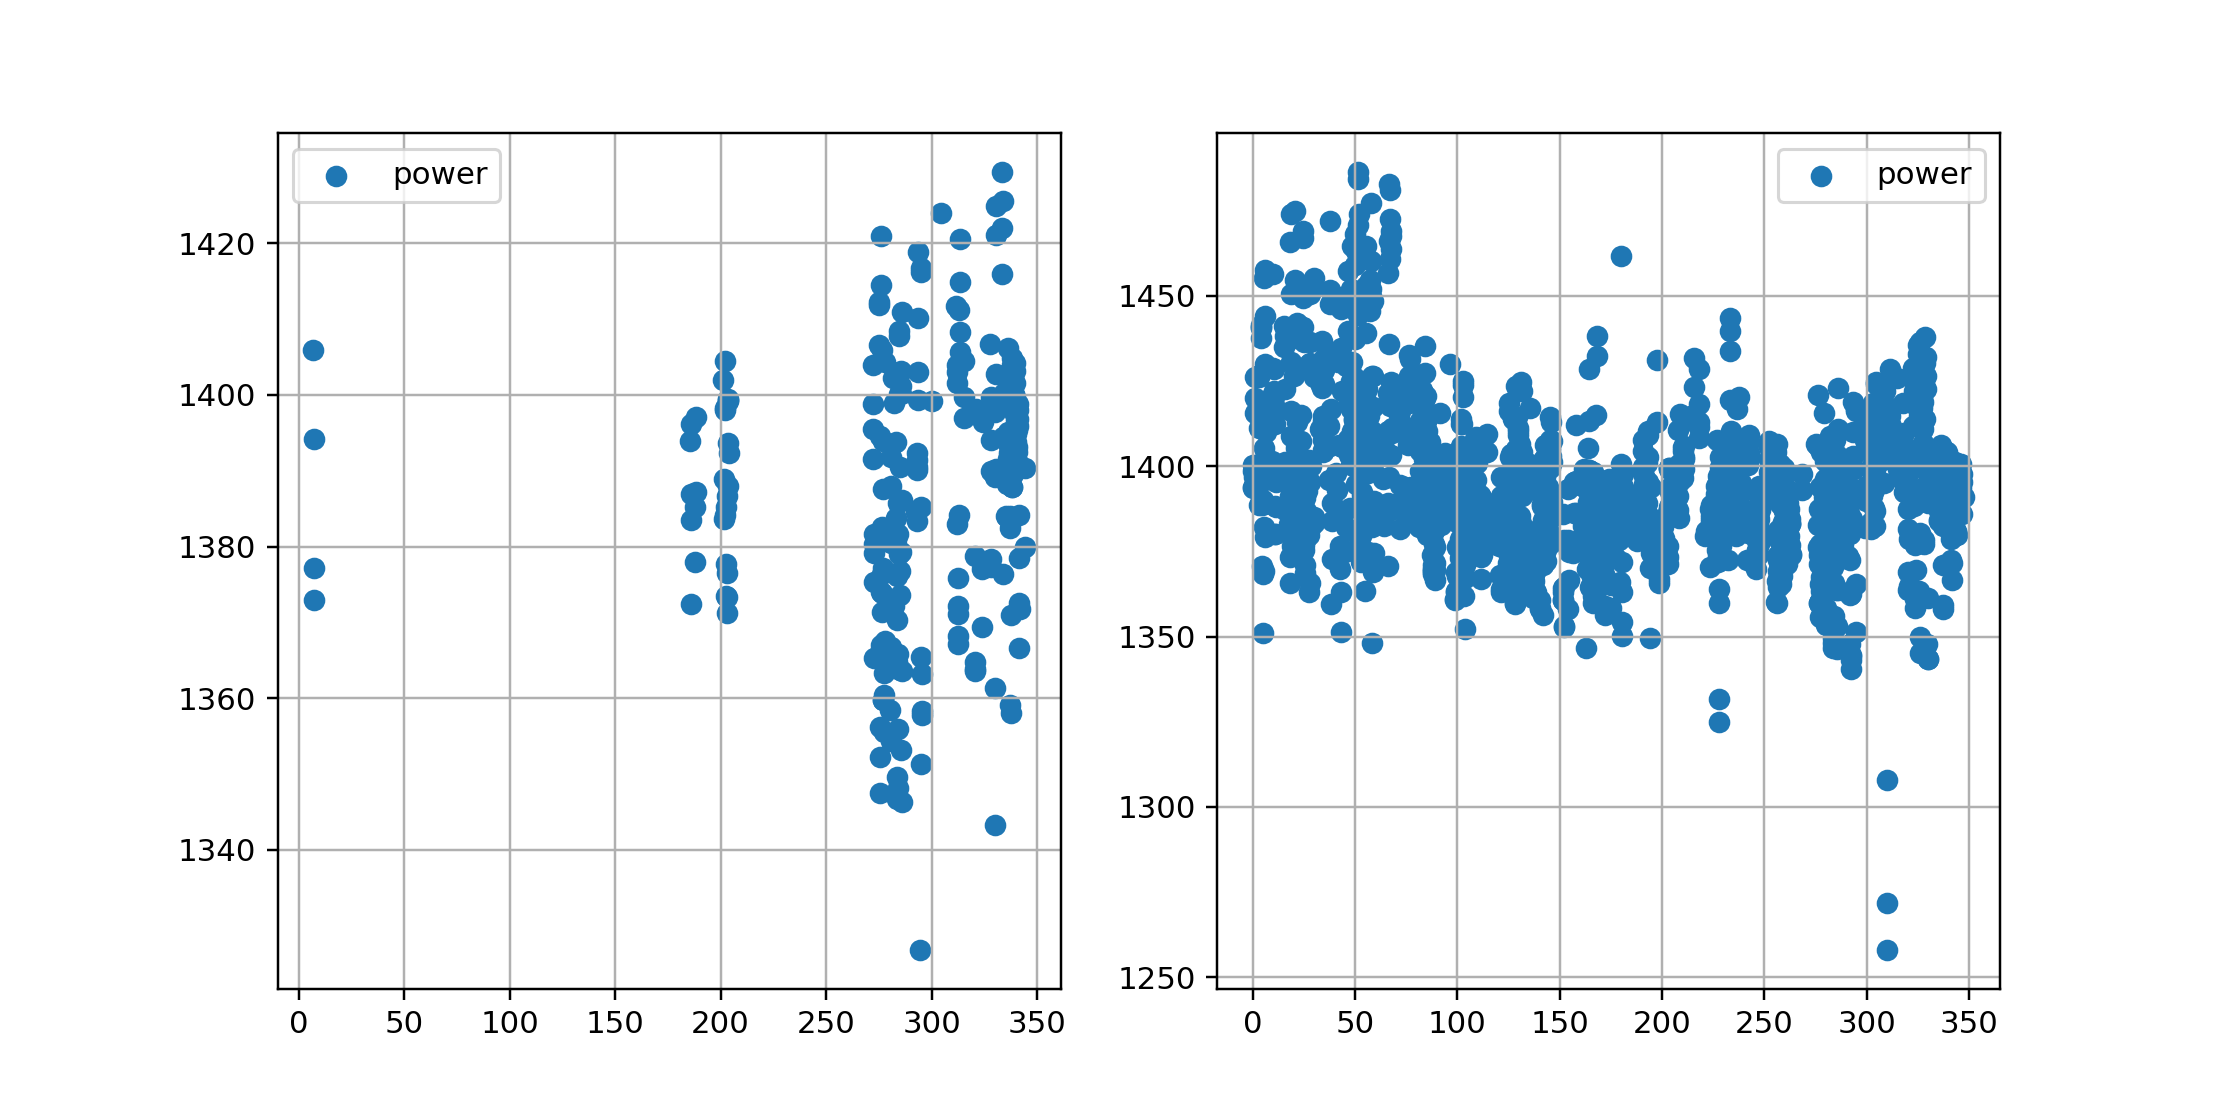

Mean power (raw) = 1386.8969488905038
Std power (raw) = 17.960225147938033
Mean power (filtered) = 1393.838433502344
Std power (filtered) = 23.649949772627714


In [20]:
# power plot
fig3, ax3 = plt.subplots(1,2, figsize=(10,5))

ax3[0].scatter(time[v_norm_filtered], total_power[v_norm_filtered], label='power')
ax3[0].grid()
ax3[0].legend()

ax3[1].scatter(time[dv_norm_filtered], total_power[dv_norm_filtered], label='power')
ax3[1].grid()
ax3[1].legend()

print("Mean power (raw) = {}".format(np.mean(total_power[v_norm_filtered])))
print("Std power (raw) = {}".format(np.std(total_power[v_norm_filtered])))

print("Mean power (filtered) = {}".format(np.mean(total_power[dv_norm_filtered])))
print("Std power (filtered) = {}".format(np.std(total_power[dv_norm_filtered])))

In [22]:
# calculate std curve
th_range = np.linspace(0,0.5,51)
std = np.zeros(51)
for i in range(51):
    indices = np.where(v_norm < th_range[i])[0]
    std[i] = np.std(total_power[indices])

<IPython.core.display.Javascript object>


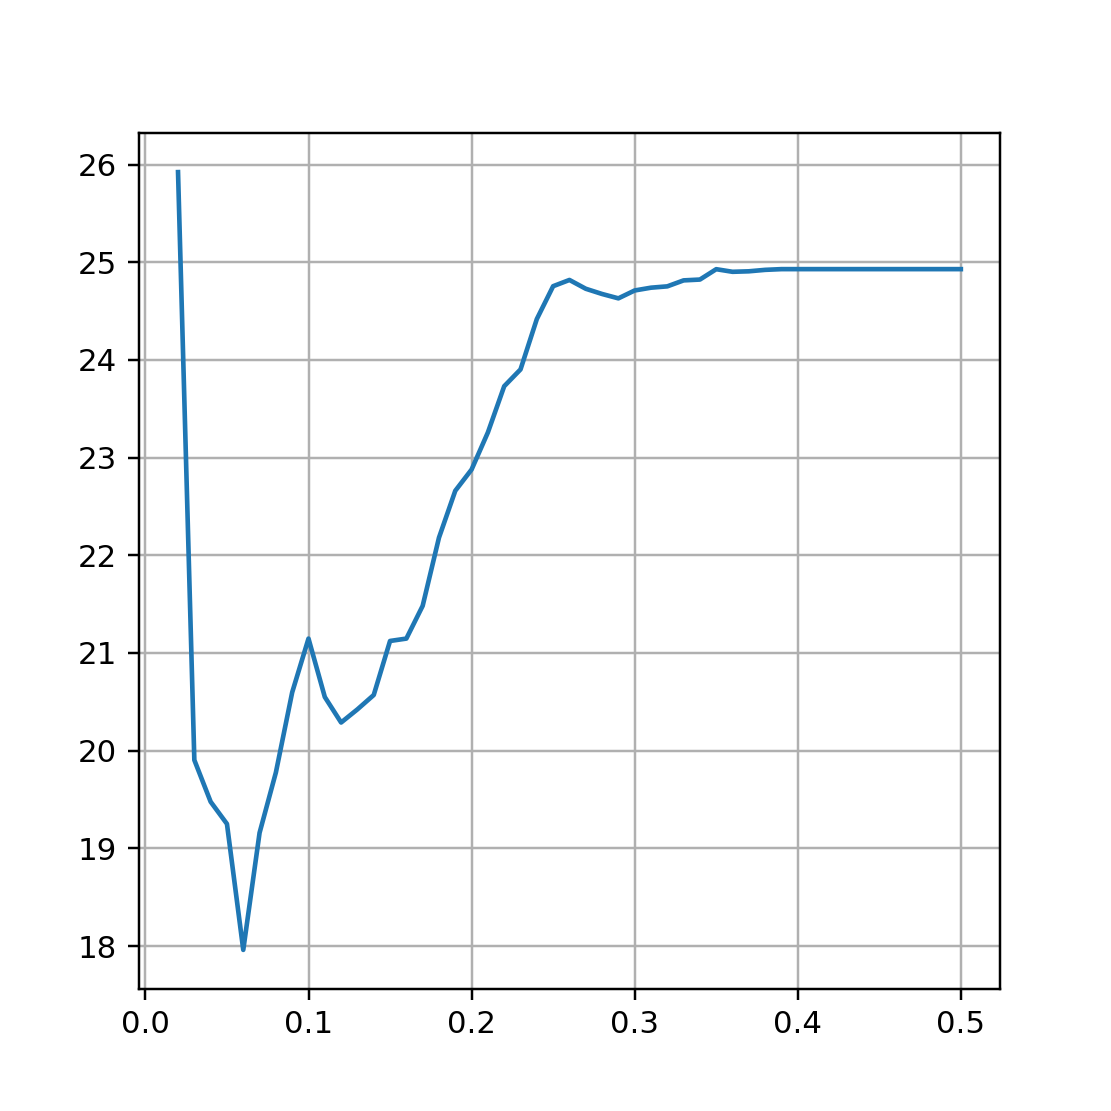

In [23]:
figx, axx = plt.subplots(figsize=(5,5))
axx.plot(th_range, std)
axx.grid()

# Garbage area

In [24]:
# compare raw and interpolated data

csvfile = '../flight_data/2022-01-24_hangar/tmp/log_145_2022-1-24-13-00-42_vehicle_local_position_0.csv'
raw_data = pd.read_csv(csvfile, sep=',', index_col='timestamp')
raw_data = raw_data[150:-100]

In [25]:
#t_spread = max(raw_data['timestamp_sample']) - min(raw_data['timestamp_sample'])
t_index = ((raw_data.index - min(raw_data.index))/10**6)
t_index = (t_index/t_index[-1])*time[-1]

In [26]:
time

array([9.99741472e-02, 1.99948294e-01, 2.99922442e-01, ...,
       3.47710084e+02, 3.47810058e+02, 3.47910032e+02])

In [27]:
t_index.values

array([0.00000000e+00, 9.87346510e-02, 1.97412074e-01, ...,
       3.47712698e+02, 3.47811347e+02, 3.47910032e+02])

<IPython.core.display.Javascript object>


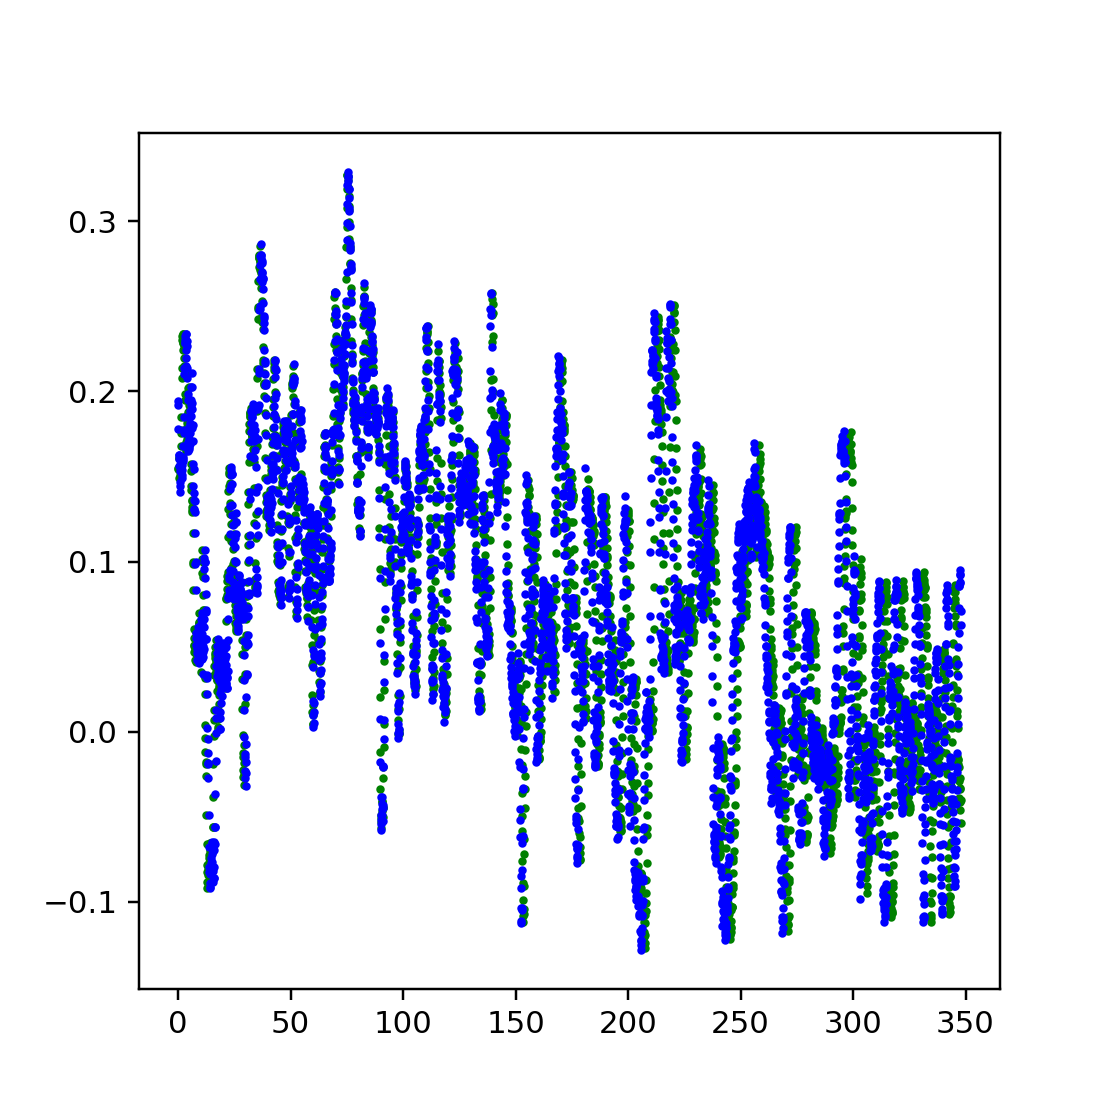

In [28]:
# check if raw and interpolatet data match

fig5, ax5 = plt.subplots(figsize=(5,5))

ax5.scatter(time, u ,c='g', label='raw data', s=markersize)
ax5.scatter(t_index, raw_data['vx'] ,c='b', label='raw data', s=markersize)

In [29]:
min(raw_data['vx'])

-0.128268